# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

# 1. Is the distribution of body temperatures normal?
Below shows the histogram of temperature.It is a graphical nomality check. 
To investigate further, statistical normality tests were performed including Shapiro-Wilk Test, D'Agostino and Pearson's Test, and Anderson-Darling Test. All of them failed to reject null hypothesis, which means the data is normal. 

### Note to myself
<li> Null hypothesis: sample is drawn from normal distribution
<li> p-value <= alpha: reject h0, not normal
<li> p-value > alpha: fail to reject h0, normal


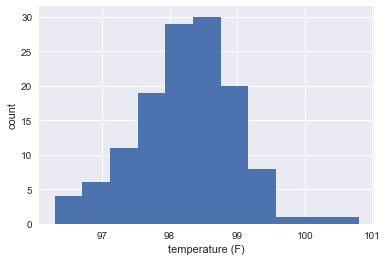

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
n_data = len(df)
n_bins = np.sqrt(n_data)
n_bins = int(n_bins)

plt.hist(df['temperature'], bins = n_bins)
plt.xlabel('temperature (F)')
plt.ylabel('count')
plt.show()

In [61]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

data = df['temperature'] 
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Data looks normal (fail to reject H0)')
else:
	print('Data does not look normal (reject H0)')

Statistics=0.987, p=0.233
Normal distribution (fail to reject H0)


In [62]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest

data = df['temperature'] 
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Data looks normal (fail to reject H0)')
else:
	print('Data does not look normal (reject H0)')

Statistics=2.704, p=0.259
Normal distribution (fail to reject H0)


In [64]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson

data = df['temperature'] 
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.520
15.000: 0.560, data looks normal (fail to reject H0)
10.000: 0.637, data looks normal (fail to reject H0)
5.000: 0.765, data looks normal (fail to reject H0)
2.500: 0.892, data looks normal (fail to reject H0)
1.000: 1.061, data looks normal (fail to reject H0)


# 2. Is the sample size large? Are the observations independent?
The data has 35 samples which is large enough for central limit theorem. 

In [73]:
import numpy as np
sample1 = np.random.choice(df['temperature'], size = 35)

In [74]:
#chi-squared test for independency
from scipy import stats
stats.chi2_contingency(sample1)[0:3]

(0.0, 1.0, 0)

X2= 0, p-value = 1 and degrees of freedom = 0
Fail to reject h0 (sample is independent). Therefore, sample is independent

# 3. Is the true population mean really 98.6 degrees F?

<p>Bootstrap hyphothesis test</p>
h0 = the true population mean is 98.6 degrees F

In [78]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [79]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [85]:
translated_temp = df['temperature'] - np.mean(df['temperature']) + 98.6
bs_replicates = draw_bs_reps(translated_temp, np.mean, size = 30)
p = np.sum(bs_replicates <= np.mean(df['temperature'])) / 30
print('p = ', p)

p =  0.0


One sample test should be used becuase it tests the mean of a single group against a known mean

In [95]:
n = np.sqrt(len(bs_replicates))
t = (98.6 - np.mean(bs_replicates))/((np.std(bs_replicates)/n))
t

0.3547169458013111

With degrees of freedom = 29 and alpha = 0.05, t-value = 1.699
Since our calcualted value is less than t-value from the table, null hyphothesis is likely to be true


# 4. Draw a small sample of size 10 from the data and repeat both frequentist tests. 
<ul>
<li> Which one is the correct one to use? 
<p> Since sample size is only 10, t should be used.
<li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
</ul>

In [96]:
sample2 = np.random.choice(df['temperature'], size = 10)
n = np.sqrt(len(sample2))
t = (98.6 - np.mean(sample2))/((np.std(sample2)/n))
t

-0.747667179418871

# 5. At what temperature should we consider someone's temperature to be "abnormal"?
<ul>
<li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
<li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
</ul>

In [107]:
import math
sample_size = 1
sample3 = np.random.choice(a= df['temperature'], size = sample_size)
sample_mean = sample3.mean()

z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*

print("z-critical value:")              # Check the z-critical value
print(z_critical)                        

temp_stdev = df.temperature.std()  # Get the population standard deviation

margin_of_error = z_critical * (temp_stdev/math.sqrt(sample_size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Margin of error")
print(margin_of_error)


print("Confidence interval:")
print(confidence_interval)

z-critical value:
1.959963984540054
Margin of error
1.4370125838276715
Confidence interval:
(96.36298741617233, 99.23701258382766)


# 6. Is there a significant difference between males and females in normal temperature?
<ul>
<li> What testing approach did you use and why?
<p> paired sample z test to compare two groups
<li> Write a story with your conclusion in the context of the original problem.

<p> h0 = male temperature and female temperature are the same
</ul>

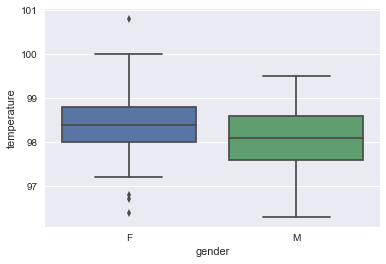

In [108]:
sns.boxplot(x='gender', y='temperature', data = df)

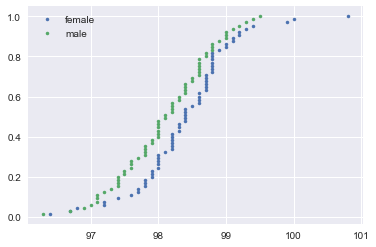

In [109]:
df1 = df.copy()
dff = df1[df1['gender'] == 'F']
dfm = df1[df1['gender'] == 'M']
dff_x = np.sort(dff['temperature'])
dff_y = np.arange(1, len(dff_x)+1) / len(dff_x)
dfm_x = np.sort(dfm['temperature'])
dfm_y = np.arange(1, len(dfm_x)+1) / len(dfm_x)
plt.plot(dff_x, dff_y, dfm_x, dfm_y, marker='.', linestyle='none')
plt.legend(('female', 'male'))

In [121]:
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
s1 = np.std(dff['temperature'])
n1 = 65
s2 = np.std(dfm['temperature'])
n2 = 65
p1 = s1/n1
p2 = s2/n2
p = (s1 + s2)/(n1+n2)
z = (p2-p1)/ ((p*(1-p)*((1/n1)+(1/n2)))**0.5)

p_value = norm.cdf(z)

print(['{:.12f}'.format(a) for a in (abs(z), p_value * 2)])

z1, p_value1 = sm.stats.proportions_ztest([s1, s2], [n1, n2])

print(['{:.12f}'.format(b) for b in (z1, p_value1)])

['0.037309489158', '0.970238239508']
['0.037309489158', '0.970238239508']


z-score is 0.037 and p-value is 0.97. fail to reject h0. Therefore, there is 

# Notes

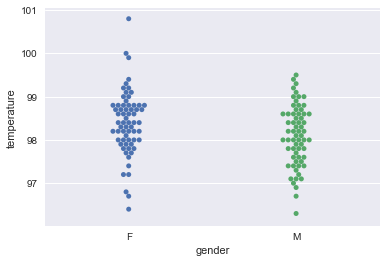

In [15]:
sns.swarmplot(x='gender', y='temperature', data = df)

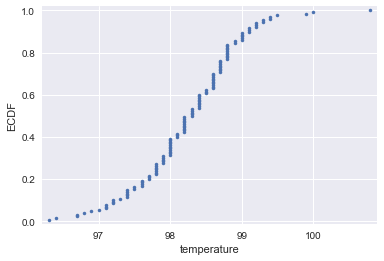

In [21]:
# plot empirical cumulative distribution functions (ECDF)
x = np.sort(df['temperature'])
y = np.arange(1, len(x)+1) / len(x)
plt.xlabel('temperature')
plt.ylabel('ECDF')
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02) # keep data off the edges

In [36]:
np.mean(dff)

temperature    98.393846
heart_rate     74.153846
dtype: float64

In [37]:
np.mean(dfm)

temperature    98.104615
heart_rate     73.369231
dtype: float64

In [47]:
np.mean(df)

temperature    98.249231
heart_rate     73.761538
dtype: float64

In [46]:
np.median(dff['temperature'])

98.4

In [48]:
np.median(dfm['temperature'])

98.1

In [49]:
np.percentile(df['temperature'], [25,50,75])

array([97.8, 98.3, 98.7])

In [51]:
np.var(dff['temperature'])

0.5442698224852062

In [52]:
np.std(dff['temperature'])

0.7377464486428966

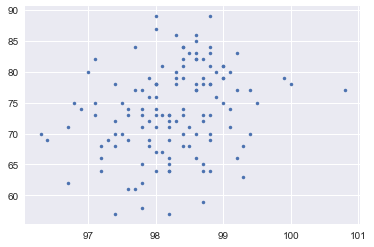

In [53]:
plt.plot(df['temperature'], df['heart_rate'], marker='.', linestyle='none')

In [56]:
covariance_matrix = np.cov(df['temperature'], df['heart_rate'])
tem_heart_cov = covariance_matrix[0,1]
tem_heart_cov

1.3133810375670796